<a href="https://www.kaggle.com/code/arthurcoss/clip-model-56a5c0?scriptVersionId=117948743" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [9]:
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.6.4


# Image Encoder

In [10]:
#getting the image
from pathlib import Path
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array,array_to_img

images_path = Path('/kaggle/input/clip-dataset/resized_train/resized_train')
text_path = '/kaggle/input/clip-dataset/caption_prediction_train.csv'

data_img=[]
#for now we only consider a small subset of images
cout = 0
for name in list(images_path.glob('*')):
        es = load_img(name)
        x=img_to_array(es)
        data_img.append(x)
        cout+=1
        if cout>=100:
            break

X_train=np.array(data_img)
X_train.shape
print(f"Total num of images: {X_train.shape[0]}")
print(f"Size of images: {X_train.shape[1:]}")

Total num of images: 100
Size of images: (128, 128, 3)


What is missing?
* -train val split
* -a better dataloader

In [11]:
# We'll resize input images to this size
image_size = X_train.shape[1]
# Size of the patches to be extract from the input images
patch_size = 8  
num_patches = (image_size // patch_size) ** 2
print(image_size,patch_size,num_patches)

128 8 256


In [12]:
data_augmentation = tfk.Sequential(
    [
        tfkl.Normalization()
#         tfkl.Resizing(image_size, image_size)
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(X_train)

In [13]:
class Patches(tfkl.Layer):
    # Custom Layer to extract patches from images
    # patch_size: size of the patches to be extracted
    def __init__(self, patch_size, **kwargs):
        # Initialize the layer
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        # Extract patches from images
        # images: 4D tensor of shape (batch_size, height, width, channels)
        batch_size = tf.shape(images)[0]
        
        # Extracts patches from the images tensor and returns a 4D tensor
        # shape (batch_size, num_patches, patch_height, patch_width, channels)
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        # Get patch dimension
        patch_dims = patches.shape[-1]
        
        # Reshape the patches to have shape (batch_size, num_patches, patch_height * patch_width * channels)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 128 X 128
Patch size: 8 X 8
Patches per image: 256
Elements per patch: 192


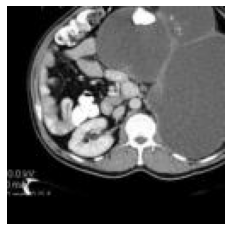

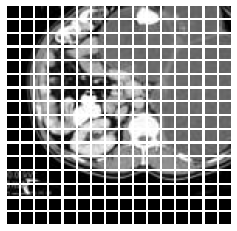

In [14]:
plt.figure(figsize=(4, 4))

# Randomly select an image from the training set
image = X_train[np.random.choice(range(X_train.shape[0]))]

# Plot the original image
plt.imshow(image.astype("uint8"))
plt.axis("off")

# Resize the image to the specified image size
resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))

# Extract patches from the resized image using the Patches layer
patches = Patches(patch_size)(resized_image)

# Print the image and patch size, number of patches per image, and number of elements per patch
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

# Plot the patches
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    # Reshape the patch to (patch_size, patch_size, 3)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [49]:
# Define the embedding dimention
projection_dim = 64
input_shape = X_train.shape[1:]

(128, 128, 3)


# Vanilla ViT

In [16]:
class PatchEncoder(tfkl.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = tfkl.Dense(units=projection_dim)
        self.position_embedding = tfkl.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        # Project the patch into a lower-dimensional space
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        # Add position embedding to the encoded patch
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [17]:
def transformer_block(x, heads, key_dim, units, dropout_rate, name=''):

    # normalize the input
    x1 = tfkl.LayerNormalization(epsilon=1e-6)(x)
    # apply multi-head attention to the normalized input
    attention_output, attention_weights = tfkl.MultiHeadAttention(
        num_heads=heads, 
        key_dim=key_dim, 
        dropout=dropout_rate, 
        name=name+'att'
    )(x1, x1, return_attention_scores=True)
    # apply dropout to the attention output
    attention_output = tfkl.Dropout(dropout_rate)(attention_output)
    # add the attention output to the original input
    x2 = tfkl.Add()([attention_output, x1])
    # normalize the result of the addition
    x3 = tfkl.LayerNormalization(epsilon=1e-6)(x2)    
    # apply a dense layer with the gelu activation function
    x3 = tfkl.Dense(units, activation=tf.nn.gelu)(x3)
    # apply dropout to the dense layer output
    x3 = tfkl.Dropout(dropout_rate)(x3)
    # add the dense layer output to the result of the addition
    x3 = tfkl.Add()([x3, x2])

    return x3, attention_weights

In [18]:
def get_visual_transformer(
    blocks, 
    heads, 
    key_dim, 
    units, 
    num_patches, 
    projection_dim, 
    dropout_rate=0.33
    ):
    
    inputs = tfkl.Input(shape=input_shape, name='inputs')
    # Augment data
    augmented = data_augmentation(inputs)
    # Create patches
    patches = Patches(patch_size)(augmented)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    for b in range(blocks):
        encoded_patches, attention_weights = transformer_block(
            encoded_patches, 
            heads, 
            key_dim, 
            units,
            dropout_rate,
            name='block'+str(b)+'_'
        )
    
    # Create a [batch_size, projection_dim] tensor
    representation = tfkl.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tfkl.Flatten()(representation)
    representation = tfkl.Dropout(0.5)(representation)
    # Classify outputs
    logits = tfkl.Dense(num_classes)(representation) #num_classes = dim of latent representation of image
    # Create the Keras model
    model = tfk.Model(inputs=inputs, outputs=logits)
    return model

What we want is a latent representation of an image.

now the output of the encoder is (None, 256, 64) which is (bz, num of patches, dim of embeding for each patch)

we try to  

In [19]:
num_classes=64
ViT = get_visual_transformer(
    blocks=4,
    heads=4,
    key_dim=projection_dim,
    units=projection_dim,
    projection_dim=projection_dim,
    num_patches=num_patches
)

In [20]:
ViT.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 128, 128, 3)  7           inputs[0][0]                     
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 192)    0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 256, 64)      28736       patches_1[0][0]                  
______________________________________________________________________________________________

# Text Encoder


In [21]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array,array_to_img

vocab_size = 20000
sequence_length = 32
batch_size = 5

data = pd.read_csv('/kaggle/input/clip-dataset/caption_prediction_train.csv',header=0, sep='\t')

vectorise = tfkl.TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
captions = data['caption'].to_numpy()
vectorise.adapt(captions)

# IMG_train, IMG_test, Cap_train, Cap_test = train_test_split(data['image'].to_numpy(),captions, test_size=0.33, random_state=seed)

In [79]:

def make_dataset(data):
    data = data[:100]
    path2img = '/kaggle/input/clip-dataset/resized_train/resized_train/'

    def load_image(link):
        return img_to_array(load_img(path2img+link+'.jpg'))
    
    #loading image
    data['image'] = data['ID'].apply(load_image)

    

    ## Tokenise the language
    captions = vectorise(data['caption'].to_list())
    
    images = data['image'].to_list()
    
    In = list(np.eye(len(images)))
    
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE)
    dataset = dataset.batch(BATCH_SIZE).cache()
    return dataset

train_dataset = make_dataset(data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [71]:
train_dataset.take(1)

<TakeDataset shapes: ((None, 128, 128, 3), (None, 32)), types: (tf.float32, tf.int64)>

# Text Model


In [23]:
class TokenAndPositionEmbedding(tfkl.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Embedding layer for the token
        self.token_emb = tfkl.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Embedding layer for the position
        self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # Find the maximum length of the input
        maxlen = tf.shape(x)[-1]
        # Create a tensor with positions from 0 to maxlen-1
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Embed the positions
        positions = self.pos_emb(positions)
        # Embed the tokens
        x = self.token_emb(x)
        # Add the token and position embeddings
        return x + positions

class TransformerEncoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential(
            [
                tfkl.Dense(ff_dim, activation="relu"), 
                tfkl.Dense(embed_dim)
            ]
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfkl.Dropout(rate)
        self.dropout2 = tfkl.Dropout(rate)
        
    def call(self, inputs, training):
        # Self-attention
        attn_output = self.att(inputs, inputs)
        # Apply dropout to the attention output
        attn_output = self.dropout1(attn_output, training=training)
        # Add the attention output to the input and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward
        ffn_output = self.ffn(out1)
        # Apply dropout to the feed-forward output
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add the feed-forward output to the previous output and normalize
        return self.layernorm2(out1 + ffn_output)

In [24]:
embed_dim = 64 # Embedding size for each token
latent_dim = 1024 # Dimention of the latent space
num_heads = 4 # Number of attention heads

encoder_inputs = tfk.Input(shape=(sequence_length,), dtype="int64", name="encoder_inputs")
# Adding token and position embedding layer
x = TokenAndPositionEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
# Adding transformer encoder block
encoder_outputs = TransformerEncoderBlock(embed_dim, num_heads, latent_dim)(x)
# Defining the encoder model
# Apply global average pooling
x = tfkl.GlobalAveragePooling1D()(encoder_outputs)
# Apply dropout
x = tfkl.Dropout(0.5)(x)
# Add a dense layer with softmax activation
outputs = tfkl.Dense(64, activation="relu")(x)
encoder_text = tfk.Model(encoder_inputs, outputs)
# Print the summary of the encoder model
encoder_text.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 32)]              0         
_________________________________________________________________
token_and_position_embedding (None, 32, 64)            1282048   
_________________________________________________________________
transformer_encoder_block (T (None, 32, 64)            198784    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
Total params: 1,484,992
Trainable params: 1,484,992
Non-trainable params: 0
_________________________________________________

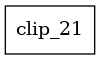

In [108]:
class CLIP(tfk.Model):
    def __init__(self, textEncoder, imageEncoder):
        super().__init__()
        self.textEncoder = textEncoder
        self.imageEncoder = imageEncoder

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.t_loss_metric = tfk.metrics.MeanSquaredError(name="t_loss")
        self.i_loss_metric = tfk.metrics.MeanSquaredError(name="i_loss")

    @property
    def metrics(self):
        return [self.i_loss_metric, self.t_loss_metric]

    def train_step(self, images_captions):
        images, captions = images_captions
        print(images.shape, captions.shape)
        
        # Encode text
        outputText = self.textEncoder(captions)
        # Encode text
        outputImage = self.imageEncoder(images)

        norm_text = tf.math.l2_normalize(outputText).numpy()
        norm_image = tf.math.l2_normalize(outputImage).numpy()
        prediction = tf.matmul(norm_image, norm_text, transpose_b=True)
        
        print(norm_image
,norm_text
,prediction)
        
        

        # Train the discriminator
        with tf.GradientTape() as tape:
            loss = self.loss_fn(np.eye(prediction.shape[0]), predictions)
            print(loss)
        grads = tape.gradient(loss, self.textEncoder.trainable_weights + self.imageEncoder.trainable_weights)
        self.optimizer.apply_gradients(
            zip(grads, self.textEncoder.trainable_weights + self.imageEncoder.trainable_weights)
        )

        # Update metrics
        self.t_loss_metric.update_state(loss)
        self.i_loss_metric.update_state(loss)
        return {
            "i_loss": self.i_loss_metric.result(),
            "t_loss": self.t_loss_metric.result(),
        }

contrast_model = CLIP(encoder_text,ViT)
tfk.utils.plot_model(contrast_model)

In [109]:
learning_rate = 0.0001
epochs = 1  # In practice, use ~100 epochs

optimizer = tfk.optimizers.Adam(learning_rate)
loss = tfk.losses.MeanSquaredError()
contrast_model.compile(optimizer, loss)


contrast_model.fit(train_dataset, epochs=epochs)
contrast_model.history()

(None, 128, 128, 3) (None, 32)


AttributeError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /tmp/ipykernel_23/963969665.py:27 train_step
        norm_text = tf.math.l2_normalize(outputText).numpy()
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:401 __getattr__
        self.__getattribute__(name)

    AttributeError: 'Tensor' object has no attribute 'numpy'
